# Overview

**GENERAL THOUGHTS:**



**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

continuous data:
- Impute missing data: SimpleImputer(strategy='median')
- Standardize data: StandardScaler()

categorical data:
- Impute missing data: SimpleImputer(strategy='most_frequent')
- Ordinal & Nominal data encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
- Unknown values ecoding: custom encoder "OrdinalEncoderExtensionUnknowns()"

target data:
- target encoding: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

**MULTI-CLASS CLASSIFIER:**
- Overview models to be considered:  
  - [X] Neural Net: Multi Layer Perceptron (MLP)


In [1]:
colab = True

In [2]:
if colab:
  # Import the library to mount Google Drive
  from google.colab import drive
  # Mount the Google Drive at /content/drive
  drive.mount('/content/drive')
  # Verify by listing the files in the drive
  # !ls /content/drive/My\ Drive/
  # current dir in colab
  !pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [3]:
if colab:
    !pip install optuna==3.5.0
    # !pip install optuna.integration
    !pip install lightning

In [5]:
# import os
import sys
import yaml
import copy

import pandas as pd
from sklearn.metrics import classification_report
import optuna
from optuna.integration import PyTorchLightningPruningCallback

import lightning as L
from lightning.pytorch.tuner import Tuner
import torch
from torchmetrics.classification import MulticlassF1Score
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# NOTE: if used in google colab, upload env_vars_colab.yml to current google colab directory!

# get config
if colab:
    with open('./env_vars_colab.yml', 'r') as file:
        config = yaml.safe_load(file)

    # custom imports
    sys.path.append(config['project_directory'])
else:
    with open('../env_vars.yml', 'r') as file:
        config = yaml.safe_load(file)

    # custom imports
    sys.path.append(config['project_directory'])

from src.tabular_lightning import (
    TabularDataModuleClassificationPACKAGING,
    MulticlassTabularLightningModule,
    MulticlassTabularMLP
)
from src.callbacks import ValPercentageEarlyStopping
from src import tabular_lightning_utils as tl_utils

In [7]:
SEED = 42 # Ensure same data split as in other notebooks

# Models and Training/HPO

In [8]:
class OptunaObjective(object):
    """Optuna objective for hyperparameter tuning."""
    def __init__(self, optuna_config) -> None:
        self.optuna_config = optuna_config
        self.dm = TabularDataModuleClassificationPACKAGING(
            data_dir=f"{config['data_directory']}/output/df_ml.csv",
            continuous_cols=['material_weight'],
            categorical_cols=[
                'material_number',
                'brand',
                'product_area',
                'core_segment',
                'component',
                'manufactoring_location',
                'characteristic_value',
                'packaging_code'
            ],
            target=['packaging_category'],
            oversampling=True,
            test_size=0.2,
            val_size=0.2,
            batch_size=64,
            SEED=SEED
        )
        self.dm.prepare_data()
        self.dm.setup(stage='fit')
        tl_utils.check_data_consitancy(self.dm)
        tl_utils.check_dataloader_output(self.dm, next(iter(self.dm.train_dataloader())))

        tabular_data_full = pd.concat([self.dm.train_dataset.get_dataframe, self.dm.val_dataset.get_dataframe, self.dm.test_dataset.get_dataframe], axis=0, ignore_index=True)
        self.embedding_sizes_cat_features = tl_utils.get_cat_feature_embedding_sizes(tabular_data_full, categorical_cols=self.dm.categorical_cols)

    def __call__(self, trial: optuna.Trial) -> float:

        # joblib.dump(study, 'study.pkl')

        # Define the hyperparameter search space
        hp_space_optuna = {
            'hidden_size': trial.suggest_categorical('hidden_size', [8, 16, 32, 64, 128]), # number of neurons in each layer
            'n_hidden_layers': trial.suggest_int("n_hidden_layers", 1, 6), # number of layers
            'batch_size': trial.suggest_categorical("batch_size", [16, 32, 64]), # number of samples per batch
            'dropout': trial.suggest_categorical("dropout", [0.0, 0.1, 0.2, 0.4]), # dropout rate
        }
        # Create a datamodule
        dm = copy.deepcopy(self.dm) # deep copy for distributed training
        dm.batch_size = hp_space_optuna['batch_size']
        # Create a model
        model = MulticlassTabularMLP(
            input_size=len(dm.feature_cols),
            output_size=dm.n_classes,
            hidden_size=hp_space_optuna['hidden_size'],
            n_hidden_layers=hp_space_optuna['n_hidden_layers'],
            dropout=hp_space_optuna['dropout'],
            norm=True,
        )
        # Create a LightningModule
        lightningmodel = MulticlassTabularLightningModule(
            model=model,
            learning_rate=0.001,
            train_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
            val_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
            test_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
        )
        # Create a trainer
        trainer = L.Trainer(
            devices="auto", # (os.cpu_count() / 2)
            callbacks=[
                # EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
                ValPercentageEarlyStopping(monitor='val_loss', mode='min', patience=5, min_delta_percentage=0.01),
                PyTorchLightningPruningCallback(trial, monitor="val_loss"),
            ],
            max_epochs=self.optuna_config["trainer_max_epochs"],
            precision='bf16-mixed',
            default_root_dir="lightning_logs/",
        )
        # Create a Tuner
        tuner = Tuner(trainer)
        lr_finder = tuner.lr_find(lightningmodel, datamodule=dm) # finds learning rate automatically
        new_lr = lr_finder.suggestion()
        lightningmodel.learning_rate = new_lr # update hparams of the model
        trial.set_user_attr("learning_rate", new_lr) # Track learning_rate as a user attribute
        # Train the model
        trainer.fit(
            model=lightningmodel,
            train_dataloaders=dm.train_dataloader(),
            val_dataloaders=dm.val_dataloader()
        )

        # score = trainer.test(model=lightningmodel, dataloaders=self.dm.test_dataloader())
        # score[0]['test_F1_macro_weighted']

        return trainer.callback_metrics["val_F1_macro_weighted"].item()

In [9]:
model_name = "MLP-v2"
optuna_config = {
    "experiment_name": model_name,
    "study_storage_directory": config['optuna_storage_directory'],
    "study_n_trials": 50,
    "study_timeout": 25000, # default=None, 3600 seconds/hour
    "study_n_jobs": -1,
    "pruning": True,
    "trainer_max_epochs": 100,
}
optuna_config["storage_name"] = f"sqlite:///{optuna_config['study_storage_directory']}/{optuna_config['experiment_name']}.db"

In [10]:
# define hyper-parameter space, model + training, optimization metric via Objective
objective = OptunaObjective(optuna_config)

# define and run study for optimization
study = optuna.create_study(
    study_name=optuna_config['experiment_name'],
    storage=optuna_config["storage_name"],
    load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.SuccessiveHalvingPruner() if optuna_config['pruning'] else optuna.pruners.NopPruner(),
)

# define duration of the optimization process by and/or number_of_trails and timeout
study.optimize(
    objective,
    n_trials=optuna_config["study_n_trials"],
    timeout=optuna_config["study_timeout"],
    n_jobs=optuna_config["study_n_jobs"],
    show_progress_bar=True
)

[I 2024-11-06 12:47:30,395] Using an existing study with name 'MLP-v2' instead of creating a new one.


  0%|          | 0/50 [00:00<?, ?it/s]

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU availabl

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.003311311214825908
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.003311311214825908
INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_f0b0a06d-2bc3-4e6f-8f85-3a9db140e797.ckpt
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_f0b0a06d-2bc3-4e6f-8f85-3a9db140e797.ckpt
INFO: Learning rate set to 0.006918309709189364
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.006918309709189364
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_34608320-f34e-4cc1-8042-1bfeef75afed.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 12:50:59,335] Trial 21 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0002511886431509582
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0002511886431509582
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_0446c2ef-c8f5-470a-a913-3ce151e546ea.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_0446c2ef-c8f5-470a-a913-3ce151e546ea.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_0446c2ef-c8f5-470a-a913-3ce151e546ea.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_0446c2ef-c8f5-470a-a913-3ce151e546ea.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 55.6 K | train
1 | train_a

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 12:55:41,950] Trial 23 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.003311311214825908
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.003311311214825908
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_528f3b63-806e-464a-a35e-7cc254673136.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_528f3b63-806e-464a-a35e-7cc254673136.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_528f3b63-806e-464a-a35e-7cc254673136.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_528f3b63-806e-464a-a35e-7cc254673136.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 89.1 K | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:01:31,932] Trial 24 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.017378008287493765
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.017378008287493765
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_86378558-38d6-4213-a856-fbd16e77d4e0.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_86378558-38d6-4213-a856-fbd16e77d4e0.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_86378558-38d6-4213-a856-fbd16e77d4e0.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_86378558-38d6-4213-a856-fbd16e77d4e0.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 3.6 K  | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:06:20,712] Trial 22 finished with value: 0.22394542396068573 and parameters: {'hidden_size': 128, 'n_hidden_layers': 1, 'batch_size': 32, 'dropout': 0.4}. Best is trial 3 with value: 0.6107561588287354.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.005754399373371567
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005754399373371567
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_c249cf18-693d-4aa4-a19b-52f734e9e994.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_c249cf18-693d-4aa4-a19b-52f734e9e994.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_c249cf18-693d-4aa4-a19b-52f734e9e994.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_c249cf18-693d-4aa4-a19b-52f734e9e994.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 24.1 K | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:07:08,202] Trial 25 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00478630092322638
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.00478630092322638
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_10e37bf8-05c6-4acd-b5f1-0bd48c5a4724.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_10e37bf8-05c6-4acd-b5f1-0bd48c5a4724.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_10e37bf8-05c6-4acd-b5f1-0bd48c5a4724.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_10e37bf8-05c6-4acd-b5f1-0bd48c5a4724.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 24.1 K | train
1 | train_acc |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:09:04,267] Trial 26 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.012022644346174132
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.012022644346174132
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_c03e837e-673b-42d6-b0f0-8dc57aa0c04c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_c03e837e-673b-42d6-b0f0-8dc57aa0c04c.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_c03e837e-673b-42d6-b0f0-8dc57aa0c04c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_c03e837e-673b-42d6-b0f0-8dc57aa0c04c.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 24.1 K | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:11:33,154] Trial 28 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_22cf2d74-c943-476c-9674-1a40dde73e49.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_22cf2d74-c943-476c-9674-1a40dde73e49.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_22cf2d74-c943-476c-9674-1a40dde73e49.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_22cf2d74-c943-476c-9674-1a40dde73e49.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 19.8 K | train
1 | train_acc | MulticlassF1Score    | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:13:09,447] Trial 27 pruned. Trial was pruned at epoch 4.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.025118864315095822
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.025118864315095822
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_8b27549c-5730-485e-b54d-c2310b877dee.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_8b27549c-5730-485e-b54d-c2310b877dee.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_8b27549c-5730-485e-b54d-c2310b877dee.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_8b27549c-5730-485e-b54d-c2310b877dee.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 709    | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:13:58,022] Trial 29 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.07585775750291836
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.07585775750291836
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_e0f48f5d-7d17-4d87-8103-45f31fbc41e6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_e0f48f5d-7d17-4d87-8103-45f31fbc41e6.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_e0f48f5d-7d17-4d87-8103-45f31fbc41e6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_e0f48f5d-7d17-4d87-8103-45f31fbc41e6.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 621    | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
-----------------------------------------------------------
621       Trainable params
0         Non-trainable params
621       Total params
0.002     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 621    | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:22:53,385] Trial 30 finished with value: 0.045432548969984055 and parameters: {'hidden_size': 8, 'n_hidden_layers': 4, 'batch_size': 64, 'dropout': 0.1}. Best is trial 3 with value: 0.6107561588287354.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.012022644346174132
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.012022644346174132
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_dff979b7-9380-4d12-a93f-f2ed956f27bd.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_dff979b7-9380-4d12-a93f-f2ed956f27bd.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_dff979b7-9380-4d12-a93f-f2ed956f27bd.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_dff979b7-9380-4d12-a93f-f2ed956f27bd.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 55.6 K | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:25:19,249] Trial 31 finished with value: 0.03449322283267975 and parameters: {'hidden_size': 8, 'n_hidden_layers': 3, 'batch_size': 32, 'dropout': 0.1}. Best is trial 3 with value: 0.6107561588287354.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Validation: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.005754399373371567
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005754399373371567
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_ffe99373-4915-40e7-9396-c8574881b8e5.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_ffe99373-4915-40e7-9396-c8574881b8e5.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_ffe99373-4915-40e7-9396-c8574881b8e5.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_ffe99373-4915-40e7-9396-c8574881b8e5.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 105 K  | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:27:39,386] Trial 32 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.02089296130854041
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.02089296130854041
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_0a447f91-c45a-4cc9-8f0f-521b9a798311.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_0a447f91-c45a-4cc9-8f0f-521b9a798311.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_0a447f91-c45a-4cc9-8f0f-521b9a798311.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_0a447f91-c45a-4cc9-8f0f-521b9a798311.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 28.4 K | train
1 | train_acc |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:48:57,905] Trial 34 finished with value: 0.03449322283267975 and parameters: {'hidden_size': 64, 'n_hidden_layers': 6, 'batch_size': 16, 'dropout': 0.2}. Best is trial 3 with value: 0.6107561588287354.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.012022644346174132
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.012022644346174132
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_4b8a1331-cac3-45a8-95bd-5aa68c88a08a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_4b8a1331-cac3-45a8-95bd-5aa68c88a08a.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_4b8a1331-cac3-45a8-95bd-5aa68c88a08a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_4b8a1331-cac3-45a8-95bd-5aa68c88a08a.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 5.8 K  | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:49:49,431] Trial 33 pruned. Trial was pruned at epoch 4.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00478630092322638
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.00478630092322638
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_ac1b33a3-2d48-4a3e-a647-3a1c559c9578.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_ac1b33a3-2d48-4a3e-a647-3a1c559c9578.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_ac1b33a3-2d48-4a3e-a647-3a1c559c9578.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_ac1b33a3-2d48-4a3e-a647-3a1c559c9578.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 22.0 K | train
1 | train_acc |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:52:41,210] Trial 35 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.005754399373371567
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005754399373371567
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_42054e6f-f24a-41c9-8e4a-79f6e0eb8c72.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_42054e6f-f24a-41c9-8e4a-79f6e0eb8c72.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_42054e6f-f24a-41c9-8e4a-79f6e0eb8c72.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_42054e6f-f24a-41c9-8e4a-79f6e0eb8c72.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 22.0 K | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 13:59:07,897] Trial 36 pruned. Trial was pruned at epoch 4.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.005754399373371567
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005754399373371567
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_ba9b7369-7430-4654-b17b-623d36f3ee45.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_ba9b7369-7430-4654-b17b-623d36f3ee45.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_ba9b7369-7430-4654-b17b-623d36f3ee45.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_ba9b7369-7430-4654-b17b-623d36f3ee45.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 38.8 K | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:01:53,680] Trial 37 pruned. Trial was pruned at epoch 4.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.09120108393559097
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.09120108393559097
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_cdf8d2dc-2d19-4768-828d-dc2b89c19bd6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_cdf8d2dc-2d19-4768-828d-dc2b89c19bd6.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_cdf8d2dc-2d19-4768-828d-dc2b89c19bd6.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_cdf8d2dc-2d19-4768-828d-dc2b89c19bd6.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 533    | train
1 | train_acc |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:03:51,529] Trial 38 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.10964781961431852
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.10964781961431852
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_1bd59766-38ff-44f7-ab63-2688a52a229a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_1bd59766-38ff-44f7-ab63-2688a52a229a.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_1bd59766-38ff-44f7-ab63-2688a52a229a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_1bd59766-38ff-44f7-ab63-2688a52a229a.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 533    | train
1 | train_acc |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:16:04,899] Trial 40 finished with value: 0.045432548969984055 and parameters: {'hidden_size': 8, 'n_hidden_layers': 2, 'batch_size': 32, 'dropout': 0.4}. Best is trial 3 with value: 0.6107561588287354.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.09120108393559097
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.09120108393559097
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_e3d60001-d548-43e2-89e8-4287b3d9fce4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_e3d60001-d548-43e2-89e8-4287b3d9fce4.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_e3d60001-d548-43e2-89e8-4287b3d9fce4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_e3d60001-d548-43e2-89e8-4287b3d9fce4.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 989    | train
1 | train_acc |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:19:14,494] Trial 39 finished with value: 0.03449322283267975 and parameters: {'hidden_size': 8, 'n_hidden_layers': 2, 'batch_size': 32, 'dropout': 0.4}. Best is trial 3 with value: 0.6107561588287354.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Validation: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.030199517204020192
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.030199517204020192
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_39cda320-4fa2-421b-a0ba-47a866baf973.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_39cda320-4fa2-421b-a0ba-47a866baf973.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_39cda320-4fa2-421b-a0ba-47a866baf973.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_39cda320-4fa2-421b-a0ba-47a866baf973.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 989    | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:23:59,429] Trial 42 pruned. Trial was pruned at epoch 4.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.07585775750291836
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.07585775750291836
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_eb104168-cac4-48cb-82be-e5ea22b7f486.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_eb104168-cac4-48cb-82be-e5ea22b7f486.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_eb104168-cac4-48cb-82be-e5ea22b7f486.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_eb104168-cac4-48cb-82be-e5ea22b7f486.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 1.6 K  | train
1 | train_acc |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:26:00,879] Trial 41 finished with value: 0.03449322283267975 and parameters: {'hidden_size': 16, 'n_hidden_layers': 1, 'batch_size': 32, 'dropout': 0.4}. Best is trial 3 with value: 0.6107561588287354.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0630957344480193
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0630957344480193
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_45917226-b39f-4ba7-8a88-410496c273c2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_45917226-b39f-4ba7-8a88-410496c273c2.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_45917226-b39f-4ba7-8a88-410496c273c2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_45917226-b39f-4ba7-8a88-410496c273c2.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 15.5 K | train
1 | train_acc | M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:28:45,981] Trial 44 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0013182567385564075
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0013182567385564075
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_ed97545e-5f54-4e56-93c7-c6f5d710e471.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_ed97545e-5f54-4e56-93c7-c6f5d710e471.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_ed97545e-5f54-4e56-93c7-c6f5d710e471.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_ed97545e-5f54-4e56-93c7-c6f5d710e471.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 38.8 K | train
1 | train_a

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:33:39,529] Trial 45 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0630957344480193
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0630957344480193
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_7480a444-9740-4d01-a7d6-691e75d42ac9.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_7480a444-9740-4d01-a7d6-691e75d42ac9.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_7480a444-9740-4d01-a7d6-691e75d42ac9.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_7480a444-9740-4d01-a7d6-691e75d42ac9.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 989    | train
1 | train_acc | M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:35:39,406] Trial 46 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.02089296130854041
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.02089296130854041
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_6a728217-f79e-4f24-8dd3-4a75d2d41b68.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_6a728217-f79e-4f24-8dd3-4a75d2d41b68.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_6a728217-f79e-4f24-8dd3-4a75d2d41b68.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_6a728217-f79e-4f24-8dd3-4a75d2d41b68.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 989    | train
1 | train_acc |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:37:42,413] Trial 47 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.8317637711026709
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.8317637711026709
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_50fed797-1e66-4fdb-b223-f762c05599ba.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_50fed797-1e66-4fdb-b223-f762c05599ba.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_50fed797-1e66-4fdb-b223-f762c05599ba.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_50fed797-1e66-4fdb-b223-f762c05599ba.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 989    | train
1 | train_acc | M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:42:57,638] Trial 48 finished with value: 0.045432548969984055 and parameters: {'hidden_size': 16, 'n_hidden_layers': 1, 'batch_size': 64, 'dropout': 0.2}. Best is trial 3 with value: 0.6107561588287354.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.036307805477010104
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.036307805477010104
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_42762a55-beb5-4000-99f9-862b0a226657.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_42762a55-beb5-4000-99f9-862b0a226657.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_42762a55-beb5-4000-99f9-862b0a226657.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_42762a55-beb5-4000-99f9-862b0a226657.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 1.3 K  | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:43:41,884] Trial 43 finished with value: 0.045432548969984055 and parameters: {'hidden_size': 16, 'n_hidden_layers': 3, 'batch_size': 32, 'dropout': 0.4}. Best is trial 3 with value: 0.6107561588287354.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00478630092322638
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.00478630092322638
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_eda4c8d7-25c1-4b9a-b9eb-f89f48bf3159.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_eda4c8d7-25c1-4b9a-b9eb-f89f48bf3159.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_eda4c8d7-25c1-4b9a-b9eb-f89f48bf3159.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_eda4c8d7-25c1-4b9a-b9eb-f89f48bf3159.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 38.8 K | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
-----------------------------------------------------------
38.8 K    Trainable params
0         Non-trainable params
38.8 K    Total params
0.155     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 38.8 K | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:45:03,218] Trial 49 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0013182567385564075
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0013182567385564075
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_611feaba-ea40-4bc8-8fe0-1f7ae0df15ce.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_611feaba-ea40-4bc8-8fe0-1f7ae0df15ce.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_611feaba-ea40-4bc8-8fe0-1f7ae0df15ce.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_611feaba-ea40-4bc8-8fe0-1f7ae0df15ce.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 22.0 K | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
-----------------------------------------------------------
22.0 K    Trainable params
0         Non-trainable params
22.0 K    Total params
0.088     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 22.0 K | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:46:53,026] Trial 50 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_bccdc440-d889-4bab-816c-925abb7a145b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_bccdc440-d889-4bab-816c-925abb7a145b.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_bccdc440-d889-4bab-816c-925abb7a145b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_bccdc440-d889-4bab-816c-925abb7a145b.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 2.5 K  | train
1 | train_acc | MulticlassF1Score    | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:47:36,926] Trial 51 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.030199517204020192
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.030199517204020192
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_16796c22-0e93-430d-bbe4-46c89b56a86c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_16796c22-0e93-430d-bbe4-46c89b56a86c.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_16796c22-0e93-430d-bbe4-46c89b56a86c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_16796c22-0e93-430d-bbe4-46c89b56a86c.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 3.6 K  | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:50:20,932] Trial 52 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0007585775750291836
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0007585775750291836
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_f637f42a-efbb-468d-8ac9-34bceaf54c10.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_f637f42a-efbb-468d-8ac9-34bceaf54c10.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_f637f42a-efbb-468d-8ac9-34bceaf54c10.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_f637f42a-efbb-468d-8ac9-34bceaf54c10.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 38.8 K | train
1 | train_a

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:54:59,153] Trial 54 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_d44c4e60-4d7e-4059-ac5f-514698e665ca.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_d44c4e60-4d7e-4059-ac5f-514698e665ca.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_d44c4e60-4d7e-4059-ac5f-514698e665ca.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_d44c4e60-4d7e-4059-ac5f-514698e665ca.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 15.5 K | train
1 | train_acc | MulticlassF1Score    | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:56:01,201] Trial 53 pruned. Trial was pruned at epoch 4.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.005754399373371567
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.005754399373371567
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_f9c12efd-8891-4f89-b1ef-f1700ff70d00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_f9c12efd-8891-4f89-b1ef-f1700ff70d00.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_f9c12efd-8891-4f89-b1ef-f1700ff70d00.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_f9c12efd-8891-4f89-b1ef-f1700ff70d00.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 6.9 K  | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 14:59:15,862] Trial 55 pruned. Trial was pruned at epoch 1.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-11-06 14:59:30,115] Trial 56 pruned. Trial was pruned at epoch 1.


INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.02089296130854041
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.02089296130854041
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_d4e99232-94e8-42c6-bb3f-b0da40a0c0ad.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_d4e99232-94e8-42c6-bb3f-b0da40a0c0ad.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_d4e99232-94e8-42c6-bb3f-b0da40a0c0ad.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_d4e99232-94e8-42c6-bb3f-b0da40a0c0ad.ckpt
INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:li

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_3f9fe364-bf76-4df8-8a86-fe58fac58e8e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_3f9fe364-bf76-4df8-8a86-fe58fac58e8e.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_3f9fe364-bf76-4df8-8a86-fe58fac58e8e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_3f9fe364-bf76-4df8-8a86-fe58fac58e8e.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 6.9 K  | train
1 | train_acc | MulticlassF1Score    | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:05:37,245] Trial 58 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Validation: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.006918309709189364
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.006918309709189364
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_6ab0c486-1c63-4ea0-a6d2-4c7ae0d8e95b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_6ab0c486-1c63-4ea0-a6d2-4c7ae0d8e95b.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_6ab0c486-1c63-4ea0-a6d2-4c7ae0d8e95b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_6ab0c486-1c63-4ea0-a6d2-4c7ae0d8e95b.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 6.9 K  | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:07:30,579] Trial 57 pruned. Trial was pruned at epoch 4.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.006918309709189364
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.006918309709189364
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_81760904-0d81-4f94-95d2-e11514f44532.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_81760904-0d81-4f94-95d2-e11514f44532.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_81760904-0d81-4f94-95d2-e11514f44532.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_81760904-0d81-4f94-95d2-e11514f44532.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 24.1 K | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:09:02,112] Trial 59 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.000630957344480193
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.000630957344480193
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_de6a73a2-5df0-482f-a285-9e28cd9720ac.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_de6a73a2-5df0-482f-a285-9e28cd9720ac.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_de6a73a2-5df0-482f-a285-9e28cd9720ac.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_de6a73a2-5df0-482f-a285-9e28cd9720ac.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 72.3 K | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:11:58,738] Trial 60 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.008317637711026709
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.008317637711026709
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_d5e2e82d-65f8-48dd-bc1b-6322926feb33.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_d5e2e82d-65f8-48dd-bc1b-6322926feb33.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_d5e2e82d-65f8-48dd-bc1b-6322926feb33.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_d5e2e82d-65f8-48dd-bc1b-6322926feb33.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 72.3 K | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:13:04,423] Trial 61 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.01
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_6edcbaf1-3490-4cc9-a76f-0c0cc579df2e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_6edcbaf1-3490-4cc9-a76f-0c0cc579df2e.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_6edcbaf1-3490-4cc9-a76f-0c0cc579df2e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_6edcbaf1-3490-4cc9-a76f-0c0cc579df2e.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 38.8 K | train
1 | train_acc | MulticlassF1Score    | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:16:07,971] Trial 62 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00478630092322638
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.00478630092322638
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_a49846ad-b70c-4c1f-a429-2ebdfc40b941.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_a49846ad-b70c-4c1f-a429-2ebdfc40b941.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_a49846ad-b70c-4c1f-a429-2ebdfc40b941.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_a49846ad-b70c-4c1f-a429-2ebdfc40b941.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 38.8 K | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
-----------------------------------------------------------
38.8 K    Trainable params
0         Non-trainable params
38.8 K    Total params
0.155     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 38.8 K | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:20:18,217] Trial 63 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.00478630092322638
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.00478630092322638
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_08119ff8-399a-4160-8153-a309f4810267.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_08119ff8-399a-4160-8153-a309f4810267.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_08119ff8-399a-4160-8153-a309f4810267.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_08119ff8-399a-4160-8153-a309f4810267.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 15.5 K | train
1 | train_acc |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:23:26,926] Trial 64 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0630957344480193
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0630957344480193
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_4ccf19fe-31e2-47e1-ab0f-858242ee15e9.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_4ccf19fe-31e2-47e1-ab0f-858242ee15e9.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_4ccf19fe-31e2-47e1-ab0f-858242ee15e9.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_4ccf19fe-31e2-47e1-ab0f-858242ee15e9.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 797    | train
1 | train_acc | M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:24:15,210] Trial 65 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0630957344480193
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0630957344480193
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_1a248c82-3418-40bb-b9fd-e6e4f19cea9b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_1a248c82-3418-40bb-b9fd-e6e4f19cea9b.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_1a248c82-3418-40bb-b9fd-e6e4f19cea9b.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_1a248c82-3418-40bb-b9fd-e6e4f19cea9b.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 797    | train
1 | train_acc | M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:27:13,685] Trial 66 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.030199517204020192
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.030199517204020192
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_36905182-af46-4a73-94e0-5d818f65c4e1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_36905182-af46-4a73-94e0-5d818f65c4e1.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_36905182-af46-4a73-94e0-5d818f65c4e1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_36905182-af46-4a73-94e0-5d818f65c4e1.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 797    | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:31:00,572] Trial 68 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.05248074602497723
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.05248074602497723
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_30de34d0-6aee-44c1-bfa8-4255f8be7a72.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_30de34d0-6aee-44c1-bfa8-4255f8be7a72.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_30de34d0-6aee-44c1-bfa8-4255f8be7a72.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_30de34d0-6aee-44c1-bfa8-4255f8be7a72.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 709    | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
-----------------------------------------------------------
709       Trainable params
0         Non-trainable params
709       Total params
0.003     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 709    | train
1 | train_acc | MulticlassF1Score    | 0      | train
2 | val_acc   | MulticlassF1Score    | 0      | train
3 | test_acc  | MulticlassF1Score    | 0      | train
--------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:34:43,378] Trial 69 pruned. Trial was pruned at epoch 1.


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.10964781961431852
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.10964781961431852
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_45ddff07-f1e0-4854-b1c0-9b64e84472ac.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_45ddff07-f1e0-4854-b1c0-9b64e84472ac.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_45ddff07-f1e0-4854-b1c0-9b64e84472ac.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_45ddff07-f1e0-4854-b1c0-9b64e84472ac.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 885    | train
1 | train_acc |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:35:10,137] Trial 67 finished with value: 0.045432548969984055 and parameters: {'hidden_size': 8, 'n_hidden_layers': 5, 'batch_size': 32, 'dropout': 0.1}. Best is trial 3 with value: 0.6107561588287354.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-11-06 15:39:46,906] Trial 70 pruned. Trial was pruned at epoch 4.


### Analyse Optuna study

In [11]:
# print optimization results
try:
    study = optuna.load_study(study_name=optuna_config['experiment_name'], storage=optuna_config["storage_name"])
except:
    print("Study not saved to storage. Loading study from memory.")
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
best_trial = study.best_trial
print("  Performance: ", best_trial.value)
print('  Best trial:', best_trial.params)
# print("  Params: ")
# for key, value in best_trial.params.items():
#     print(f"    {key}: {value}")

Number of finished trials: 71
Best trial:
  Performance:  0.6107561588287354
  Best trial: {'hidden_size': 128, 'n_hidden_layers': 3, 'batch_size': 32, 'dropout': 0.0}


In [12]:
# history of all trials
hist = study.trials_dataframe()
hist.head()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout,params_hidden_size,params_n_hidden_layers,user_attrs_learning_rate,system_attrs_completed_rung_0,system_attrs_completed_rung_1,state
0,0,0.045433,2024-11-05 22:39:52.050329,2024-11-06 01:00:32.527845,0 days 02:20:40.477516,32,0.1,8,4,0.043652,NaN,NaN,COMPLETE
1,1,0.458142,2024-11-05 22:39:52.052097,2024-11-06 00:36:18.604439,0 days 01:56:26.552342,64,0.1,64,5,0.008318,NaN,NaN,COMPLETE
2,2,0.530007,2024-11-06 00:36:18.982294,2024-11-06 03:43:30.171057,0 days 03:07:11.188763,32,0.2,128,2,0.006918,NaN,NaN,COMPLETE
3,3,0.610756,2024-11-06 01:00:32.984349,2024-11-06 04:34:12.344229,0 days 03:33:39.359880,32,0.0,128,3,0.004786,NaN,NaN,COMPLETE
4,4,0.045433,2024-11-06 03:43:30.476991,2024-11-06 05:24:31.593113,0 days 01:41:01.116122,64,0.2,32,6,0.014454,NaN,NaN,COMPLETE


In [13]:
# plot performance of all trials
optuna.visualization.plot_optimization_history(study)

In [14]:
# plot the parameter relationship concerning performance
optuna.visualization.plot_slice(study)

In [15]:
# plots the interactive visualization of the high-dimensional parameter relationship
optuna.visualization.plot_parallel_coordinate(study)

In [16]:
# plots parameter interactive chart from we can choose which hyperparameter space has to explore
optuna.visualization.plot_contour(study)

### Evaluate best model

In [17]:
best_trial.params

{'hidden_size': 128, 'n_hidden_layers': 3, 'batch_size': 32, 'dropout': 0.0}

INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.003311311214825908
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.003311311214825908
INFO: Restoring states from the checkpoint path at lightning_logs/.lr_find_850133f6-3bdc-429e-a786-73c3fe8cbeab.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at lightning_logs/.lr_find_850133f6-3bdc-429e-a786-73c3fe8cbeab.ckpt
INFO: Restored all states from the checkpoint at lightning_logs/.lr_find_850133f6-3bdc-429e-a786-73c3fe8cbeab.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at lightning_logs/.lr_find_850133f6-3bdc-429e-a786-73c3fe8cbeab.ckpt
INFO: 
  | Name      | Type                 | Params | Mode 
-----------------------------------------------------------
0 | model     | MulticlassTabularMLP | 55.6 K | train
1 | train_acc

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

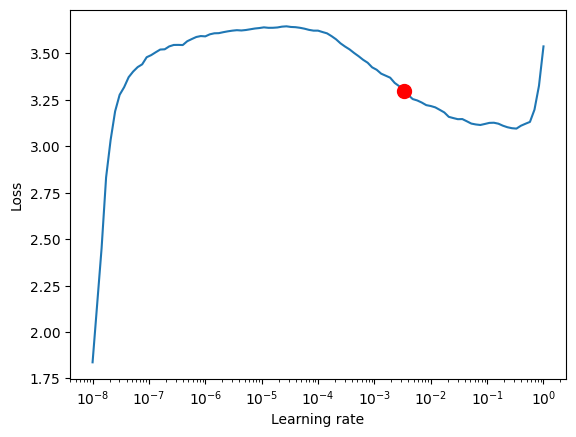

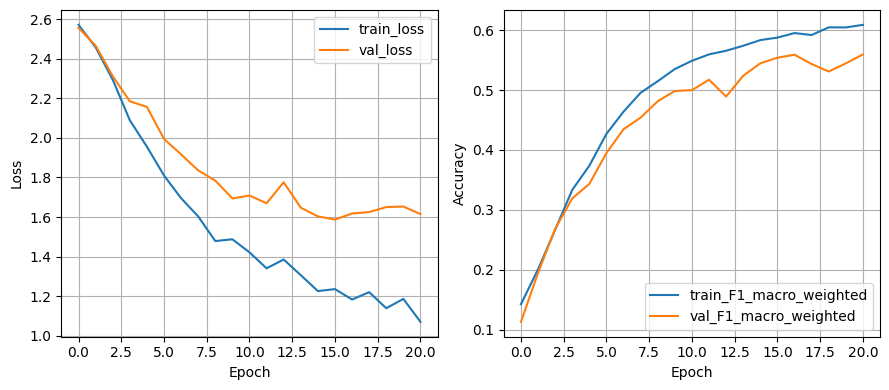

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_F1_macro_weighted   │    0.5593810081481934     │
└───────────────────────────┴───────────────────────────┘

test_F1_macro_weighted: 0.5593810081481934


In [18]:
# Define best model

best_params = best_trial.params

# Evaluate best model on test data again
def eval_best_model(best_params, optuna_config) -> None:
    # datamodule
    dm=TabularDataModuleClassificationPACKAGING(
        data_dir=f"{config['data_directory']}/output/df_ml.csv",
        continuous_cols=['material_weight'],
        categorical_cols=[
            'material_number',
            'brand',
            'product_area',
            'core_segment',
            'component',
            'manufactoring_location',
            'characteristic_value',
            'packaging_code'
        ],
        target=['packaging_category'],
        oversampling=True,
        test_size=0.2,
        val_size=0.2,
        batch_size=best_params['batch_size'],
        SEED=SEED
    )
    dm.prepare_data()
    dm.setup(stage='fit')
    # model
    best_model = MulticlassTabularMLP(
        input_size=len(dm.feature_cols),
        output_size=dm.n_classes,
        hidden_size=best_params['hidden_size'],
        n_hidden_layers=best_params['n_hidden_layers'],
        dropout=best_params['dropout'],
        norm=True,
    )
    # lightningmodel
    lightningmodel = MulticlassTabularLightningModule(
        model=best_model,
        learning_rate=0.001,
        train_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
        val_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
        test_acc = MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
    )
    # trainer
    trainer = L.Trainer(
        devices="auto", # (os.cpu_count() / 2)
        callbacks=[
            # EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
            ValPercentageEarlyStopping(monitor='val_loss', mode='min', patience=5, min_delta_percentage=0.01),
            ModelCheckpoint(
                monitor="val_loss",
                mode="min",
                save_top_k=1,
                every_n_epochs=3,
                enable_version_counter=False,
                dirpath=f"lightning_logs/checkpoints/{optuna_config['experiment_name']}",
                filename=f"best_model_{optuna_config['experiment_name']}",
            ),
        ],
        logger=CSVLogger(save_dir="logs/", name=optuna_config['experiment_name']),
        max_epochs=200,
        precision='bf16-mixed',
        default_root_dir="lightning_logs/",
    )
    # find learning rate
    tuner = Tuner(trainer)
    lr_finder = tuner.lr_find(lightningmodel, datamodule=dm) # finds learning rate automatically
    new_lr = lr_finder.suggestion()
    fig_lr = lr_finder.plot(suggest=True)
    lightningmodel.learning_rate = new_lr # update hparams of the model
    # train model
    trainer.fit(
        model=lightningmodel,
        train_dataloaders=dm.train_dataloader(),
        val_dataloaders=dm.val_dataloader()
    )
    fig_lr.savefig(f"lightning_logs/checkpoints/{optuna_config['experiment_name']}/learning_rate_best_model_{optuna_config['experiment_name']}.pdf")
    # plot training metrics
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
    tl_utils.plot_training_metrics(metrics)
    # evaluate model on test data
    score = trainer.test(model=lightningmodel, dataloaders=dm.test_dataloader())
    print(f"test_F1_macro_weighted: {score[0]['test_F1_macro_weighted']}")

    return lightningmodel.parameters, lightningmodel.learning_rate

# Evaluate best model on test data
lm_parameters, lm_learning_rate = eval_best_model(best_params, optuna_config)

# Load model from checkpoint and make predictions

In [19]:
def load_model_and_predict(
    study: optuna.Study = None,
    checkpoint_path: str = None,
) -> None:
    """Loads the best model from the checkpoint and predicts on the test set.
    Args:
        study (optuna.Study): The study object of optuna.
        checkpoint_path (str): The path to the checkpoint.
    Returns:
        None
    """
    # datamodule
    dm=TabularDataModuleClassificationPACKAGING(
        data_dir=f"{config['data_directory']}/output/df_ml.csv",
        continuous_cols=['material_weight'],
        categorical_cols=[
            'material_number',
            'brand',
            'product_area',
            'core_segment',
            'component',
            'manufactoring_location',
            'characteristic_value',
            'packaging_code'
        ],
        target=['packaging_category'],
        oversampling=True,
        test_size=0.2,
        val_size=0.2,
        batch_size=best_params['batch_size'],
        SEED=SEED
    )
    dm.prepare_data()
    dm.setup(stage='fit')
    # model
    best_model = MulticlassTabularMLP(
        input_size=len(dm.feature_cols),
        output_size=dm.n_classes,
        hidden_size=study.best_trial.params['hidden_size'],
        n_hidden_layers=study.best_trial.params['n_hidden_layers'],
        dropout=study.best_trial.params['dropout'],
        norm=True,
    )
    # Parameters that were not tracked (excluded), they need to be provided at the time of loading
    # NOTE: Those parameters are either complicated to track or were excluded to reduce logging of those parameters during training
    lighning_model_args = {
        "model": best_model,
        "learning_rate": study.best_trial.user_attrs["learning_rate"],
        # "train_acc": MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
        # "val_acc": MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
        # "test_acc": MulticlassF1Score(num_classes=dm.n_classes, average='weighted'),
    }
    # lighning_model_args["optimizer"] = torch.optim.Adam  # For compatibility. Not Used
    # lighning_model_args["loss"] = F.cross_entropy  # For compatibility. Not Used
    # lighning_model_args["optimizer_params"] = {}  # For compatibility. Not Used
    # lightning model
    best_trained_lightning_model = MulticlassTabularLightningModule.load_from_checkpoint(
        checkpoint_path=checkpoint_path,
        # map_location=torch.device('cpu'),
        strict=True,
        **lighning_model_args,
    )
    # trainer
    trainer = L.Trainer(
        devices="auto", # (os.cpu_count() / 2)
        callbacks=[
            EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5),
        ],
        precision='bf16-mixed',
        default_root_dir="lightning_logs/",
    )
    # predict
    preds_y_test = torch.cat(trainer.predict(model=best_trained_lightning_model, dataloaders=dm.test_dataloader()))
    preds_y_test = dm.label_encoder_target.inverse_transform(preds_y_test.reshape(-1, 1))
    y_test = dm.label_encoder_target.inverse_transform(dm.test_dataset.get_dataframe.iloc[:, -1].values.reshape(-1, 1))
    # calculate classification report
    print(classification_report(y_test, preds_y_test))

    return


# configs to load model from checkpoint
load_config = {
    "experiment_name": model_name,
    "study_storage_directory": config['optuna_storage_directory'],
}
load_config["storage_name"] = f"sqlite:///{load_config['study_storage_directory']}/{load_config['experiment_name']}.db"

load_model_and_predict(
    study=optuna.load_study(study_name=load_config['experiment_name'], storage=load_config["storage_name"]),
    checkpoint_path=f"lightning_logs/checkpoints/{load_config['experiment_name']}/best_model_{load_config['experiment_name']}.ckpt",
)


INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

                            precision    recall  f1-score   support

   Blister and Insert Card       0.38      0.53      0.44      1749
  Blister and sealed blist       0.56      0.61      0.59      1582
            Book packaging       1.00      0.20      0.33        20
Cardb. Sleeve w - w/o Shr.       0.07      0.02      0.03       135
  Cardboard hanger w/o bag       0.67      0.10      0.17        80
    Carton cover (Lid box)       0.90      0.36      0.52       130
   Carton tube with or w/o       1.00      0.15      0.26        20
                      Case       1.00      0.01      0.02        97
         Corrugated carton       0.68      0.47      0.55       774
        Countertop display       0.00      0.00      0.00        30
                  Envelope       1.00      0.14      0.24        59
          Fabric packaging       1.00      0.05      0.10        20
            Folding carton       0.51      0.51      0.51      1644
              Hanger/ Clip       0.61      0.88